<h1>Title</h1>

**Can we predict whether a person has a heart disease based on their age, cholesterol, and resting blood pressure?**

<h1>Introduction</h1>

Heart disease refers to a range of conditions that affect the heart and blood vessels. Among these conditions is Coronary Artery Disease (CAD), which is characterized by the narrowing of blood vessels leading to the heart. According to the World Health Organization (WHO), heart disease is the leading cause of death worldwide, with CAD accounting for the majority of these deaths. This research project analyzes data provided by the Hungarian Institute of Cardiology (processed.hungarian.data) to answer the question, “Can we use age, cholesterol and resting blood pressure measurements that are available to us to predict the risk of an individual having Coronary Artery Disease?”. The original database contains 76 attributes, but we will be working with 14 important comma-separated attributes including age, cholesterol level, and resting blood pressure.

<h1>Preliminary Exploratory Data Analysis</h1>

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Reading from web:

In [2]:
data <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data", delim=",", col_names = FALSE)
colnames(data) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
tail(data)

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
52,1,4,140,266,0,0,134,1,2.0,2,?,?,1
52,1,4,160,331,0,0,94,1,2.5,?,?,?,1
54,0,3,130,294,0,1,100,1,0.0,2,?,?,1
56,1,4,155,342,1,0,150,1,3.0,2,?,?,1
58,0,2,180,393,0,0,110,1,1.0,2,?,7,1
65,1,4,130,275,0,1,115,1,1.0,2,?,?,1


Choosing our predictors: (note that we excluded the columns "slope", "ca", and "thal" because they do not contain data)

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removing 1 row that contained a missing value”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 23 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removing 1 row that contained a missing value”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing non-finite values (stat_density).”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 24 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removing 1 r

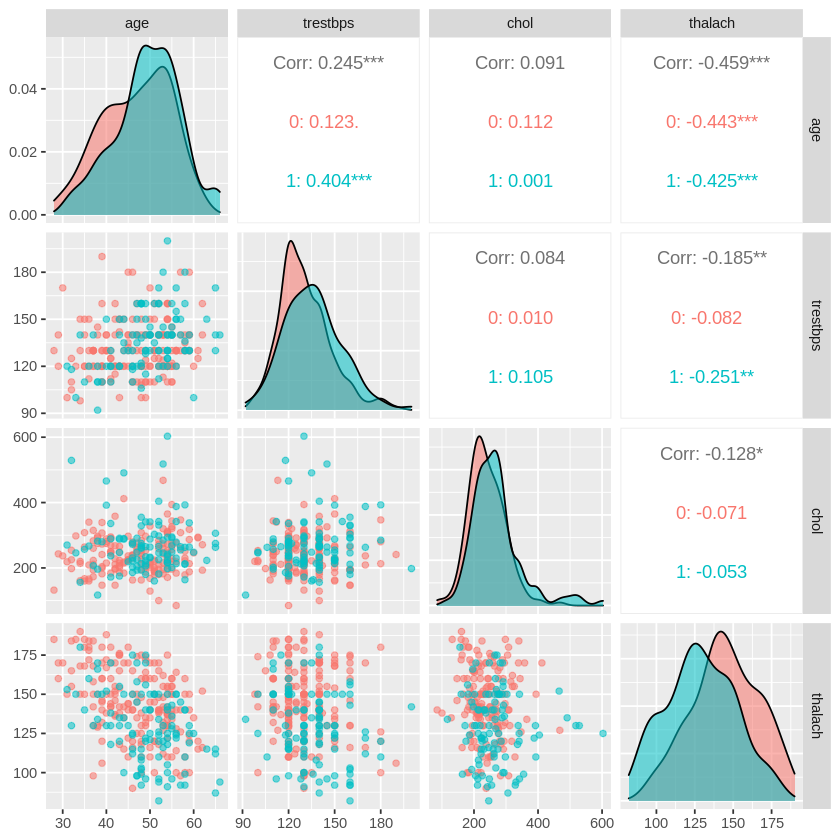

In [13]:
# age, trestbps, chol, thalach, oldpeak

pairs <- data |>
    select(age, trestbps, chol, thalach, oldpeak, num) |>
    filter(trestbps != '?' | chol != '?' | thalach != '?') |>
    mutate(trestbps = as.numeric(trestbps), chol = as.numeric(chol), thalach = as.numeric(thalach), num = as.factor(num)) |>
    ggpairs(columns = 1:4, aes(color = num, alpha = 0.2))

pairs

Cleaning, wrangling, and tidying:

In [3]:
tidy_data <- data |>
    select(age, trestbps, chol, num)

head(tidy_data)

age,trestbps,chol,num
<dbl>,<chr>,<chr>,<dbl>
28,130,132,0
29,120,243,0
29,140,?,0
30,170,237,0
31,100,219,0
32,105,198,0


Splitting into training and testing data:

In [4]:
set.seed(3456)
data_split <- initial_split(tidy_data, prop = 3/4, strata = num)
data_train <- training(data_split)
data_test <- testing(data_split)

# data_train
# data_test

Summarization of the training data:

In [5]:
missing_rows <- data_train |>
    filter(trestbps == '?' | chol == '?') |>
    count()

avg_age <- data_train |>
    select(age) |>
    colMeans()

avg_chol <- data_train |>
    select(chol) |>
    filter(chol != '?') |>
    mutate(chol = as.numeric(chol)) |>
    colMeans()

avg_trestbps <- data_train |>
    select(trestbps) |>
    filter(trestbps != '?') |>
    mutate(trestbps = as.numeric(trestbps)) |>
    colMeans()

summary_table <- data.frame(n = missing_rows, observations_used = 3, mean_age = avg_age, mean_chol = avg_chol, mean_trestbps = avg_trestbps) |>
    as_tibble() |>
    mutate(incomplete_rows = n) |>
    select(!n)

summary_table

observations_used,mean_age,mean_chol,mean_trestbps,incomplete_rows
<dbl>,<dbl>,<dbl>,<dbl>,<int>
3,48.37273,254.4902,132.589,17


`summarise()` has grouped output by 'age'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'chol'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'trestbps'. You can override using the
`.groups` argument.
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


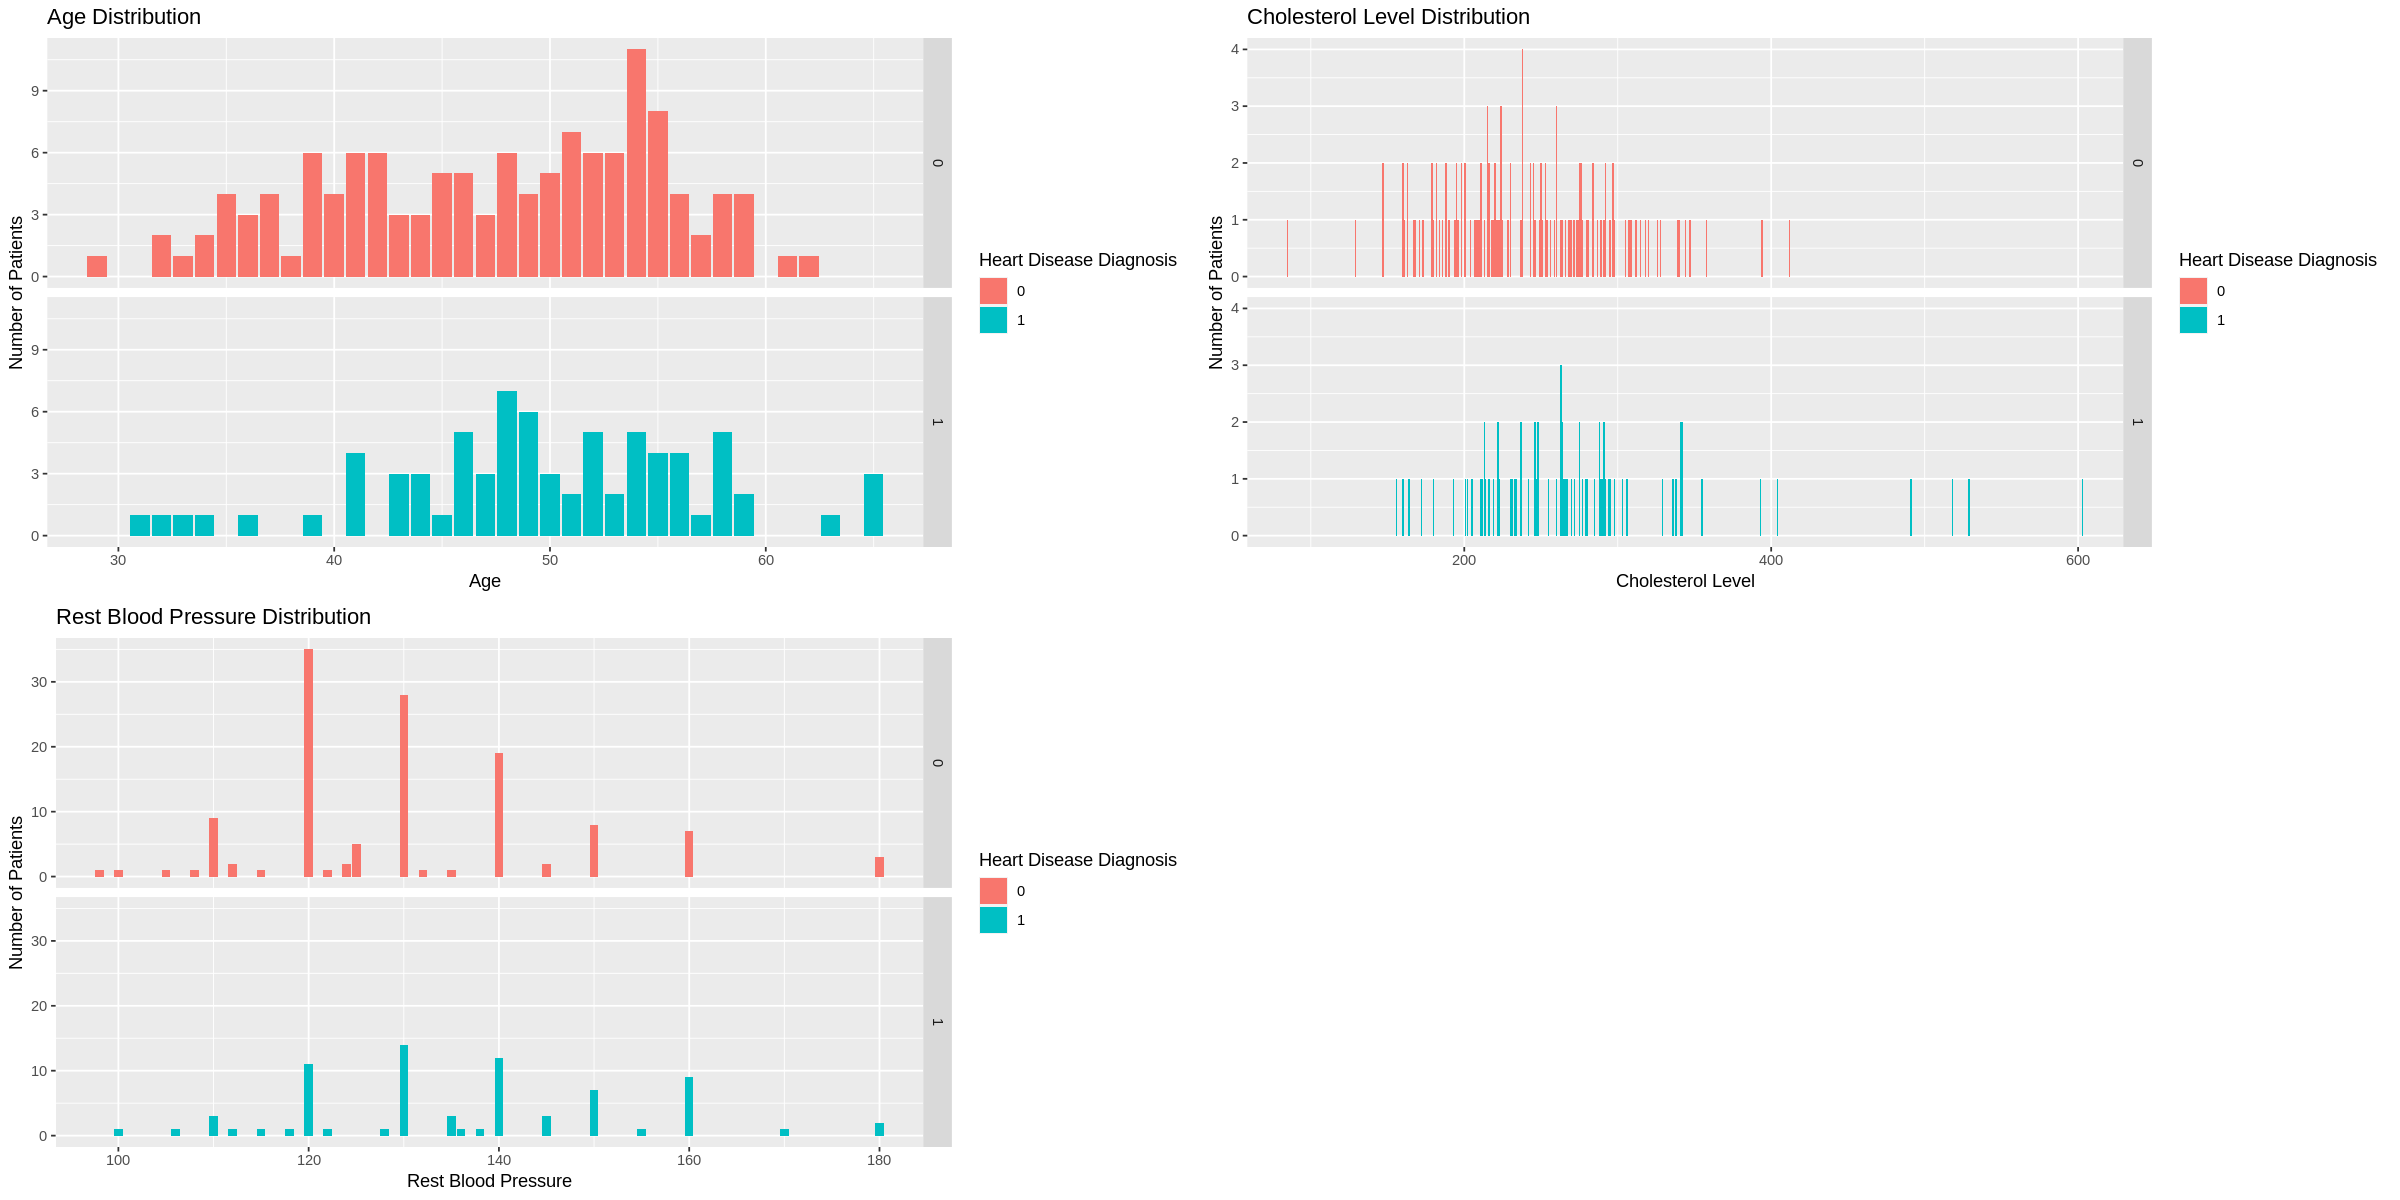

In [6]:
plottable_train_data <- data_train |>
    filter(chol != '?' & trestbps != '?') |>
    mutate(chol = as.numeric(chol), trestbps = as.numeric(trestbps), num = as.factor(num))

age_vs_count_data <- plottable_train_data |>
    group_by(age, num) |>
    summarize(count = n()) |>
    ungroup()

chol_vs_count_data <- plottable_train_data |>
    group_by(chol, num) |>
    summarize(count = n()) |>
    ungroup()

trestbps_vs_count_data <- plottable_train_data |>
    group_by(trestbps, num) |>
    summarize(count = n()) |>
    ungroup()

options(repr.plot.width = 10, repr.plot.height = 5)

age_vs_count_plot <- age_vs_count_data |>
    ggplot(aes(x = age, y = count, fill = num)) +
    geom_histogram(stat = "identity") +
    facet_grid(vars(num)) +
    labs(x = "Age", y = "Number of Patients", fill = "Heart Disease Diagnosis") +
    ggtitle("Age Distribution")
# age_vs_count_plot

chol_vs_count_plot <- chol_vs_count_data |>
    ggplot(aes(x = chol, y = count, fill = num)) +
    geom_histogram(stat = "identity") +
    facet_grid(vars(num)) +
    labs(x = "Cholesterol Level", y = "Number of Patients", fill = "Heart Disease Diagnosis") +
    ggtitle("Cholesterol Level Distribution")
# chol_vs_count_plot

trestbps_vs_count_plot <- trestbps_vs_count_data |>
    ggplot(aes(x = trestbps, y = count, fill = num)) +
    geom_histogram(stat = "identity") +
    facet_grid(vars(num)) +
    labs(x = "Rest Blood Pressure", y = "Number of Patients", fill = "Heart Disease Diagnosis") +
    ggtitle("Rest Blood Pressure Distribution")
# trestbps_vs_count_plot

options(repr.plot.width = 20, repr.plot.height = 10)
total_grid <- plot_grid(age_vs_count_plot, chol_vs_count_plot, trestbps_vs_count_plot)

total_grid

<h1>Methods</h1>

We are analyzing the Heart Disease dataset with focus on the processed Hungarian data. The aim is to develop a classification model predicting whether an individual has CAD or not based on age, cholesterol level, and resting blood pressure. Since CAD is caused by the narrowing of blood vessels from plaque build-up, the target variable for CAD diagnosis is the diameter narrowing of blood vessels. The presence of CAD can be classified by two binary labels: “0” indicates less than 50% diameter narrowing of the blood vessels, referring to the absence of CAD, and “1” indicates more than 50% narrowing of the blood vessels, referring to the presence of CAD. The continuous parameters of age, cholesterol and resting blood pressure have been strongly associated with the presence of CAD, considering that the build-up of plaque is directly related to cholesterol level and age, while blood pressure is directly related to both of those factors. The results will be primarily visualized using scatterplot graphs as they will most effectively highlight the relationships between the three parameters and target variable.

<h1>Expected Outcomes and Significance</h1>

We expect to observe that cases with higher measurements of any of the three parameters (age, cholesterol level, and resting blood pressure) are more likely to be classified as “1” for the presence of CAD. Increasing age is a non-modifiable risk factor for heart disease. High cholesterol level is typically an indicator of too much plaque in the blood vessels, which can ultimately cause major narrowing of the blood vessels, and high resting blood pressure is also a direct indicator of plaque build-up in the vessels. Heart disease often looks invisible from the outside; the first visible symptom can be a fatal incident, such as a heart attack. Thus, the ability to predict the presence of CAD, or the risk of developing CAD, will allow medical professionals to prevent unnecessary fatalities and improve the quality of life for individuals at higher risk. For future investigation, we can question whether there is another type of heart disease with similar attributions as CAD that can be predicted by the same three parameters. One step further would be investigating how to differentiate the diagnoses of these similar diseases.